# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees

Author: Haylee Oyler

**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [3]:
# Read in the data
spotify_data = pd.read_csv('data/spotify_dat.csv')

# Print the data types in spotify_data
spotify_data.dtypes

In [5]:
# Filter down to two genres
blues_data = spotify_data[spotify_data['genres'] == 'blues']
jazz_data =  spotify_data[spotify_data['genres'] == 'jazz']

# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data])

# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns={'genres' : 'genre'})
combined_data.columns

## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


In [7]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(exclude=['object', 'bool'])
numeric_features.dtypes


track_number          int64
disc_number           int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
dtype: object

<Axes: >

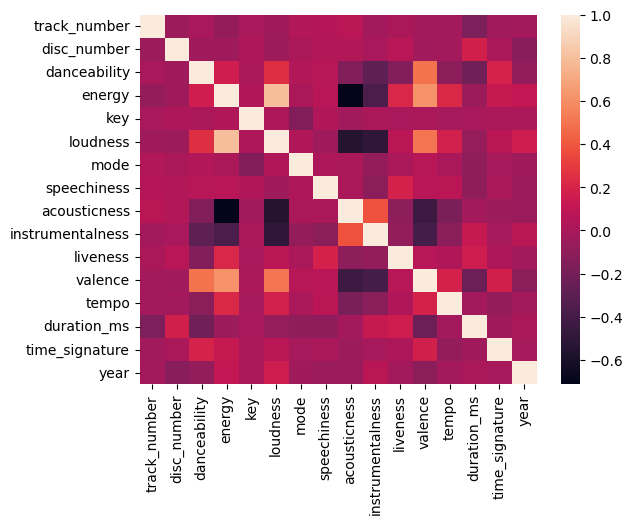

In [8]:
# Add genre back to the df
numeric_features['genre'] = combined_data['genre']

#Correlation heatmap
sns.heatmap(numeric_features.drop('genre', axis=1).corr())

<Axes: xlabel='danceability', ylabel='Count'>

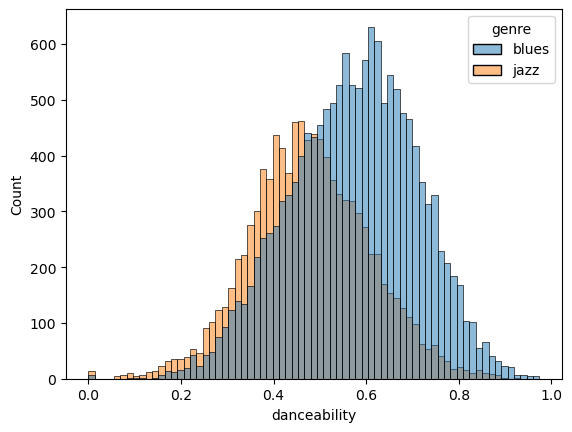

In [9]:
#Histogram of danceability
sns.histplot(data=numeric_features, x = 'danceability', hue='genre')


### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [10]:
# Print counts of each genre
class_counts = numeric_features.value_counts('genre')

# Calculate ratio of majority to minority class
class_ratio = class_counts['blues'] / class_counts['jazz']

# Print class distribution and ratio
print(f"Class distribution: {class_counts}")
print(f"\nClass ratio: {class_ratio:.4f}")

Class distribution: genre
blues    14811
jazz     10023
Name: count, dtype: int64

Class ratio: 1.4777


Given this result, should we be worried about the imbalance?

We have a class ratio of 1.47, which indicates we only have a slight class imbalance. This tells us we're generally okay and there's no need for re-balancing

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [11]:
# Define the features (drop columns that are not numeric or target)
X = numeric_features.drop('genre', axis = 1)

# Set the target variable as 'genre'
y =  numeric_features['genre']

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
print(y_encoded[:10])

[0 0 0 0 0 0 0 0 0 0]


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [12]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [13]:
# Initialize models
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)

# Train (fit) both models
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Compute training accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

#Print training accuracy for both models
print(f"K-Nearest Neighbor training accuracy: {knn_train_accuracy:.4f}")
print(f"Decision tree training accuracy: {dt_train_accuracy}")

K-Nearest Neighbor training accuracy: 0.9210
Decision tree training accuracy: 1.0


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [14]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

#Print prediction accuracy for both models
print(f"K-Nearest Neighbor training accuracy: {knn_accuracy:.4f}")
print(f"Decision tree training accuracy: {dt_accuracy:.4f}")

K-Nearest Neighbor training accuracy: 0.8917
Decision tree training accuracy: 0.8532


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

In [15]:
# Create a data frame of all 4 accuracy scores
plot_df = pd.DataFrame({
    'KNN Train Accuracy':[knn_train_accuracy],
    'KNN Accuracy': [knn_accuracy],
    'DT Train Accuracy': [dt_train_accuracy],
    'DT Accuracy':[dt_accuracy],
}, index = [0])
plot_df

,KNN Train Accuracy,KNN Accuracy,DT Train Accuracy,DT Accuracy
0,0.921025,0.891685,1.0,0.853231


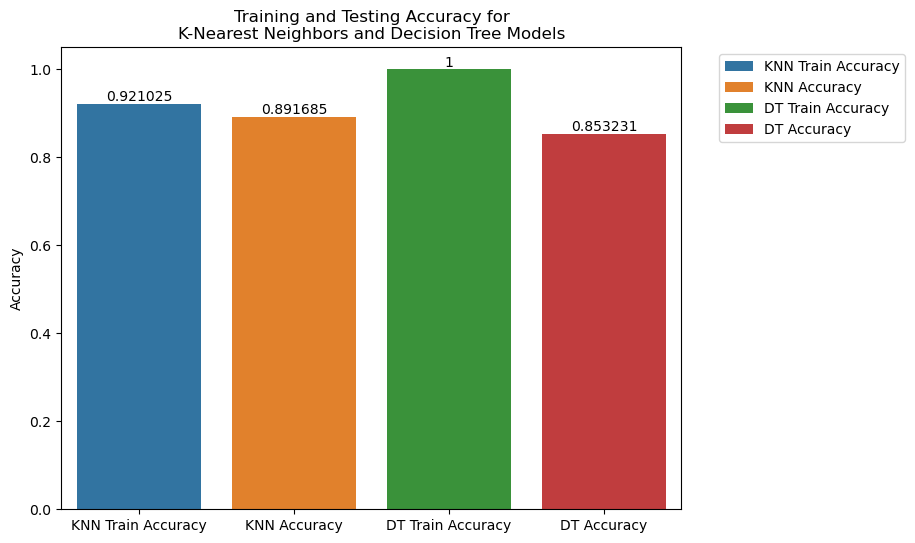

In [ ]:
# Plot accuracy scores across models
plt.figure(figsize=(8,6))

ax = sns.barplot(data = plot_df, legend=True)

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container)

plt.title('Training and Testing Accuracy for\nK-Nearest Neighbors and Decision Tree Models')
plt.ylabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc = 'upper left')
plt.show()

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

The KNN model does a better job of generalizing to unseen data because the difference between the training and the test data is much smaller than the difference for the decision tree model. The decision tree models appears to be overfitting because it has a training accuracy of 1 which indicates 100% perfect accuracy. This is unrealistic.

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

In [17]:
# Decision Tree
def decision_tree():
    # Different possible max depths
    max_depths = [2, 3, 4, 5]
    accuracies = []

    # Loop through the different k-values and fit a model/obtain accuracy
    for depth in max_depths:
        dt = DecisionTreeClassifier(max_depth=depth)
        dt.fit(X_train_scaled, y_train)

        # Make prediction and calculate accuracy
        y_pred = dt.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        print(f"Max_depth = {depth} - Accuracy: {accuracy:.3f}")

    # Visualize the effect of k on accuracy
    plt.figure(figsize=(10,6))
    plt.plot(max_depths, accuracies, marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Effect of Max Depth on Model Accuracy')
    plt.grid(True)
    plt.show()

Max_depth = 2 - Accuracy: 0.826
Max_depth = 3 - Accuracy: 0.850
Max_depth = 4 - Accuracy: 0.858
Max_depth = 5 - Accuracy: 0.875


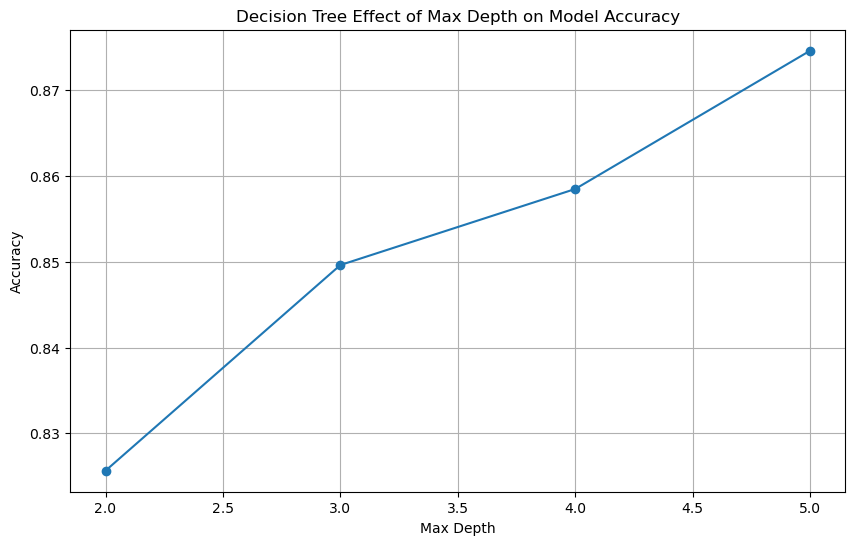

In [18]:
decision_tree()

From tuning our decision tree max depth parameter, we can see that as you increase the depth, the accuracy increases. If we set `max_depth=5`, then we see the accuracy of our decision tree increases from 0.853 to 0.875. This is only a small increase, but an increase nonetheless